# Calculating Lagrangian trajectories for coupled simulation

## Loading modules

In [1]:
%matplotlib inline
from parcels import (FieldSet, ParticleSet,
                     JITParticle, ScipyParticle,
                     AdvectionRK4,
                     Variable)
from glob import glob
import xarray as xr
import numpy as np
from datetime import timedelta, datetime
import math

## Custom settings
### need to be checked/adjusted before every execution

In [2]:
# DEFINE INPUT AND OUTPUT PATHS

############################

# set key to 'uncoupled', 'coupled_nosd', or 'coupled_sd'
key_input = 'coupled_sd'

############################

datapath = '/Users/siren/Data/IMMERSE/'

gridpath = (datapath + 'domain/fgrid.nc')

if key_input == 'uncoupled':
    filepaths_u = sorted(glob(datapath + 'surface_TKE_v42RC/MED24_OBC_1d*_grid_U.nc'))
    filepaths_v = sorted(glob(datapath + 'surface_TKE_v42RC/MED24_OBC_1d*_grid_V.nc'))
    key_stokes = False
    print('calculate trajectories for uncoupled simulation')

elif key_input == 'coupled_nosd' or key_input == 'coupled_sd':
    filepaths_u = sorted(glob(datapath + 'surface_TKE_CO_FORCE_MIX_LC015/MED24_OBC_1d*_grid_U.nc'))
    filepaths_v = sorted(glob(datapath + 'surface_TKE_CO_FORCE_MIX_LC015/MED24_OBC_1d*_grid_V.nc'))
    if key_input == 'coupled_nosd':
        key_stokes = False
        print('calculate trajectories for coupled simulation without explicit consideration of Stokes drift')
    elif key_input == 'coupled_sd':
        key_stokes = True
        print('calculate trajectories for coupled simulation with explicit consideration of Stokes drift')

else:
    print('no (valid) key_input defined')

calculate trajectories for coupled simulation with explicit consideration of Stokes drift


In [3]:
# DEFINE PARTICLE RELEASE GRID

############################

release_name = 'GulfOfLion'
lonmin = 3
lonmax = 4.5
latmin = 42
latmax = 43.5
step = 0.25
lons, lats = np.meshgrid(np.arange(lonmin, lonmax+step, step), np.arange(latmin, latmax+step, step))

tstart_release = 0 
deltat_release = 73 # days: release from the same set of locations every deltat_release days
tend_release = 365 #days
#tend_release = 73 #days

############################

lons, lats = np.meshgrid(np.arange(lonmin, lonmax+step, step),
                         np.arange(latmin, latmax+step, step))
n_releasepos = lons.shape[0]*lons.shape[1]
n_releasepos
n_particles = n_releasepos * ((tend_release-tstart_release)/deltat_release)
print('number of release points:', n_releasepos)
print('number of particles:', int(n_particles))

number of release points: 49
number of particles: 245


In [4]:
# DEFINE TRAJECTORY INTEGRATION PARAMETERS

############################

tint = 30 # days
deltat = 6 # hours

############################

In [5]:
# DEFINE LAGRANGIAN OUTPUT

############################

outdt = 1 #days

############################

procpath = '/Users/siren/IMMERSE_waves/develop-mac/data/'

if key_input == 'coupled':
    outpath = (procpath + 'Parcels_CalcTraj_Data-uncoupled_Release-' + release_name)
elif key_input == 'coupled_nosd':
    outpath = (procpath + 'Parcels_CalcTraj_Data-coupled-nosd_Release-' + release_name)
elif key_input == 'coupled_sd':
    outpath = (procpath + 'Parcels_CalcTraj_Data-coupled-sd_Release-' + release_name)

## Create fieldset

In [6]:
filenames = {'U': {'lon': gridpath, 'lat': gridpath, 'data': filepaths_u},
             'V': {'lon': gridpath, 'lat': gridpath, 'data': filepaths_v}}
variables = {'U': 'vozocrtx',
             'V': 'vomecrty'}
if key_stokes==True:
    variables_sd = {'U': 'usd',
                    'V': 'vsd'}
dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'},
              'V': {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'}}

In [7]:
fieldset = FieldSet.from_nemo(filenames, variables, dimensions,
                              allow_time_extrapolation=False,
                              time_periodic=False,
                              mesh='spherical')
if key_stokes==True:
    fieldset_sd = FieldSet.from_nemo(filenames, variables_sd, dimensions,
                                     allow_time_extrapolation=False,
                                     time_periodic=False,
                                     mesh='spherical')
    fieldset_sum = FieldSet(U=fieldset.U+fieldset_sd.U,
                            V=fieldset.V+fieldset_sd.V)
    fieldset_use = fieldset_sum
else:
    fieldset_use = fieldset

## Build and execute particle set using (summed) velocities

Kernels adopted and modified from https://github.com/OceanParcels/Parcelsv2.0PaperNorthSeaScripts

In [8]:
class BeachParticle(ScipyParticle):
        # beached : 0 sea, 1 beached, 2 after non-beach dyn
        beached = Variable('beached', dtype=np.int64, initial=2)

In [9]:
def AdvectionRK4(particle, fieldset, time):
    if particle.beached == 0:
        (u1, v1) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
        lon1, lat1 = (particle.lon + u1*.5*particle.dt, particle.lat + v1*.5*particle.dt)

        (u2, v2) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat1, lon1]
        lon2, lat2 = (particle.lon + u2*.5*particle.dt, particle.lat + v2*.5*particle.dt)

        (u3, v3) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat2, lon2]
        lon3, lat3 = (particle.lon + u3*particle.dt, particle.lat + v3*particle.dt)

        (u4, v4) = fieldset.UV[time + particle.dt, particle.depth, lat3, lon3]
        particle.lon += (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
        particle.lat += (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
        particle.beached = 2

In [10]:
def BeachTesting(particle, fieldset, time):
    if particle.beached == 2:
        (u, v) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
        if math.fabs(u) < 1e-8 and math.fabs(v) < 1e-8:
            particle.beached = 1
            print("Particle [%d] beached !! (%g %g %g %g)" % (particle.id, particle.lon, particle.lat, particle.depth, particle.time))
        else:
            particle.beached = 0

In [11]:
def DeleteParticle(particle, fieldset, time):
    if particle.beached == 1:
        particle.delete()
        print("Particle [%d] deleted !! (%g %g %g %g)" % (particle.id, particle.lon, particle.lat, particle.depth, particle.time))
        

In [12]:
def PlotParticleSet(pset,fieldset):
    plotstep=4
    pset.show(field=fieldset.U,
              domain={'N':(latmax+plotstep/2),'S':(latmin-plotstep),
                      'E': (lonmax+plotstep), 'W':(lonmin-plotstep)})

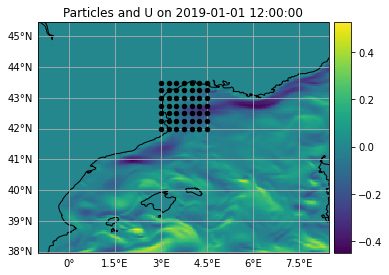

Particle [0] beached !! (3 42 0 0)
Particle [0] deleted !! (3 42 0 0)
Particle [7] beached !! (3 42.25 0 0)
Particle [7] deleted !! (3 42.25 0 0)
Particle [14] beached !! (3 42.5 0 0)
Particle [14] deleted !! (3 42.5 0 0)
Particle [21] beached !! (3 42.75 0 0)
Particle [21] deleted !! (3 42.75 0 0)
Particle [28] beached !! (3 43 0 0)
Particle [28] deleted !! (3 43 0 0)
Particle [35] beached !! (3 43.25 0 0)
Particle [35] deleted !! (3 43.25 0 0)
Particle [36] beached !! (3.25 43.25 0 0)
Particle [36] deleted !! (3.25 43.25 0 0)
Particle [42] beached !! (3 43.5 0 0)
Particle [42] deleted !! (3 43.5 0 0)
Particle [43] beached !! (3.25 43.5 0 0)
Particle [43] deleted !! (3.25 43.5 0 0)
Particle [44] beached !! (3.5 43.5 0 0)
Particle [44] deleted !! (3.5 43.5 0 0)
Particle [45] beached !! (3.75 43.5 0 0)
Particle [45] deleted !! (3.75 43.5 0 0)
Particle [47] beached !! (4.25 43.5 0 0)
Particle [47] deleted !! (4.25 43.5 0 0)
Particle [48] beached !! (4.5 43.5 0 0)
Particle [48] deleted !!

/Users/siren/opt/miniconda3/envs/py3_parcels/lib/python3.10/site-packages/matplotlib/colors.py:621: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


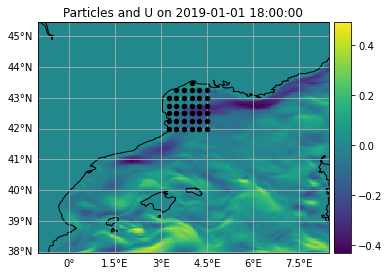

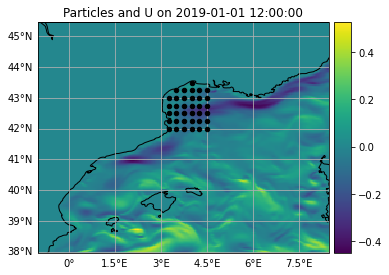

INFO: Temporary output files are stored in /Users/siren/IMMERSE_waves/develop-mac/data/out-AHSKPDOU.
INFO: You can use "parcels_convert_npydir_to_netcdf /Users/siren/IMMERSE_waves/develop-mac/data/out-AHSKPDOU" to convert these to a NetCDF file during the run.
100% (2592000.0 of 2592000.0) |##########| Elapsed Time: 0:00:07 Time:  0:00:07


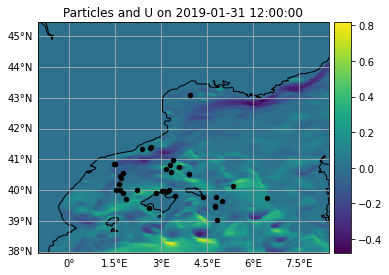

/Users/siren/opt/miniconda3/envs/py3_parcels/lib/python3.10/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


Particle [49] beached !! (3 42 0 73)
Particle [49] deleted !! (3 42 0 73)
Particle [56] beached !! (3 42.25 0 73)
Particle [56] deleted !! (3 42.25 0 73)
Particle [63] beached !! (3 42.5 0 73)
Particle [63] deleted !! (3 42.5 0 73)
Particle [70] beached !! (3 42.75 0 73)
Particle [70] deleted !! (3 42.75 0 73)
Particle [77] beached !! (3 43 0 73)
Particle [77] deleted !! (3 43 0 73)
Particle [84] beached !! (3 43.25 0 73)
Particle [84] deleted !! (3 43.25 0 73)
Particle [85] beached !! (3.25 43.25 0 73)
Particle [85] deleted !! (3.25 43.25 0 73)
Particle [91] beached !! (3 43.5 0 73)
Particle [91] deleted !! (3 43.5 0 73)
Particle [92] beached !! (3.25 43.5 0 73)
Particle [92] deleted !! (3.25 43.5 0 73)
Particle [93] beached !! (3.5 43.5 0 73)
Particle [93] deleted !! (3.5 43.5 0 73)
Particle [94] beached !! (3.75 43.5 0 73)
Particle [94] deleted !! (3.75 43.5 0 73)
Particle [96] beached !! (4.25 43.5 0 73)
Particle [96] deleted !! (4.25 43.5 0 73)
Particle [97] beached !! (4.5 43.5 0

INFO: Temporary output files are stored in /Users/siren/IMMERSE_waves/develop-mac/data/out-MOMKPUII.
INFO: You can use "parcels_convert_npydir_to_netcdf /Users/siren/IMMERSE_waves/develop-mac/data/out-MOMKPUII" to convert these to a NetCDF file during the run.
100% (2592000.0 of 2592000.0) |##########| Elapsed Time: 0:00:11 Time:  0:00:11
/Users/siren/opt/miniconda3/envs/py3_parcels/lib/python3.10/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


Particle [98] beached !! (3 42 0 146)
Particle [98] deleted !! (3 42 0 146)
Particle [105] beached !! (3 42.25 0 146)
Particle [105] deleted !! (3 42.25 0 146)
Particle [112] beached !! (3 42.5 0 146)
Particle [112] deleted !! (3 42.5 0 146)
Particle [119] beached !! (3 42.75 0 146)
Particle [119] deleted !! (3 42.75 0 146)
Particle [126] beached !! (3 43 0 146)
Particle [126] deleted !! (3 43 0 146)
Particle [133] beached !! (3 43.25 0 146)
Particle [133] deleted !! (3 43.25 0 146)
Particle [134] beached !! (3.25 43.25 0 146)
Particle [134] deleted !! (3.25 43.25 0 146)
Particle [140] beached !! (3 43.5 0 146)
Particle [140] deleted !! (3 43.5 0 146)
Particle [141] beached !! (3.25 43.5 0 146)
Particle [141] deleted !! (3.25 43.5 0 146)
Particle [142] beached !! (3.5 43.5 0 146)
Particle [142] deleted !! (3.5 43.5 0 146)
Particle [143] beached !! (3.75 43.5 0 146)
Particle [143] deleted !! (3.75 43.5 0 146)
Particle [145] beached !! (4.25 43.5 0 146)
Particle [145] deleted !! (4.25 43

INFO: Temporary output files are stored in /Users/siren/IMMERSE_waves/develop-mac/data/out-IJYGYTVP.
INFO: You can use "parcels_convert_npydir_to_netcdf /Users/siren/IMMERSE_waves/develop-mac/data/out-IJYGYTVP" to convert these to a NetCDF file during the run.
100% (2592000.0 of 2592000.0) |##########| Elapsed Time: 0:00:13 Time:  0:00:13
/Users/siren/opt/miniconda3/envs/py3_parcels/lib/python3.10/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


Particle [147] beached !! (3 42 0 219)
Particle [147] deleted !! (3 42 0 219)
Particle [154] beached !! (3 42.25 0 219)
Particle [154] deleted !! (3 42.25 0 219)
Particle [161] beached !! (3 42.5 0 219)
Particle [161] deleted !! (3 42.5 0 219)
Particle [168] beached !! (3 42.75 0 219)
Particle [168] deleted !! (3 42.75 0 219)
Particle [175] beached !! (3 43 0 219)
Particle [175] deleted !! (3 43 0 219)
Particle [182] beached !! (3 43.25 0 219)
Particle [182] deleted !! (3 43.25 0 219)
Particle [183] beached !! (3.25 43.25 0 219)
Particle [183] deleted !! (3.25 43.25 0 219)
Particle [189] beached !! (3 43.5 0 219)
Particle [189] deleted !! (3 43.5 0 219)
Particle [190] beached !! (3.25 43.5 0 219)
Particle [190] deleted !! (3.25 43.5 0 219)
Particle [191] beached !! (3.5 43.5 0 219)
Particle [191] deleted !! (3.5 43.5 0 219)
Particle [192] beached !! (3.75 43.5 0 219)
Particle [192] deleted !! (3.75 43.5 0 219)
Particle [194] beached !! (4.25 43.5 0 219)
Particle [194] deleted !! (4.25 

INFO: Temporary output files are stored in /Users/siren/IMMERSE_waves/develop-mac/data/out-ETUQNUMN.
INFO: You can use "parcels_convert_npydir_to_netcdf /Users/siren/IMMERSE_waves/develop-mac/data/out-ETUQNUMN" to convert these to a NetCDF file during the run.
100% (2592000.0 of 2592000.0) |##########| Elapsed Time: 0:00:11 Time:  0:00:11
/Users/siren/opt/miniconda3/envs/py3_parcels/lib/python3.10/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


Particle [196] beached !! (3 42 0 292)
Particle [196] deleted !! (3 42 0 292)
Particle [203] beached !! (3 42.25 0 292)
Particle [203] deleted !! (3 42.25 0 292)
Particle [210] beached !! (3 42.5 0 292)
Particle [210] deleted !! (3 42.5 0 292)
Particle [217] beached !! (3 42.75 0 292)
Particle [217] deleted !! (3 42.75 0 292)
Particle [224] beached !! (3 43 0 292)
Particle [224] deleted !! (3 43 0 292)
Particle [231] beached !! (3 43.25 0 292)
Particle [231] deleted !! (3 43.25 0 292)
Particle [232] beached !! (3.25 43.25 0 292)
Particle [232] deleted !! (3.25 43.25 0 292)
Particle [238] beached !! (3 43.5 0 292)
Particle [238] deleted !! (3 43.5 0 292)
Particle [239] beached !! (3.25 43.5 0 292)
Particle [239] deleted !! (3.25 43.5 0 292)
Particle [240] beached !! (3.5 43.5 0 292)
Particle [240] deleted !! (3.5 43.5 0 292)
Particle [241] beached !! (3.75 43.5 0 292)
Particle [241] deleted !! (3.75 43.5 0 292)
Particle [243] beached !! (4.25 43.5 0 292)
Particle [243] deleted !! (4.25 

INFO: Temporary output files are stored in /Users/siren/IMMERSE_waves/develop-mac/data/out-SCUZJXSS.
INFO: You can use "parcels_convert_npydir_to_netcdf /Users/siren/IMMERSE_waves/develop-mac/data/out-SCUZJXSS" to convert these to a NetCDF file during the run.
100% (2592000.0 of 2592000.0) |##########| Elapsed Time: 0:00:11 Time:  0:00:11
/Users/siren/opt/miniconda3/envs/py3_parcels/lib/python3.10/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


In [13]:
for times in range(tstart_release, tend_release, deltat_release):
    
    # 1. CREATE PARTICLE SET
    ## populate particles on grid
    pset = ParticleSet(fieldset=fieldset_use,
                       pclass=BeachParticle,
                       lon=lons, lat=lats, time=times)
    pset.populate_indices()
    if times == tstart_release:
        PlotParticleSet(pset,fieldset)
    ## define desired trajectory output (file name, frequency of position updates)
    outpath_final = (outpath + '-d' + str(times) + '_Integrate-fw-d' + str(tint) + '.nc' )
    outfile = pset.ParticleFile(outpath_final, 
                                outputdt=timedelta(days=outdt))
    ## ensure depth is not stored in trajectory output (not necessary for 2D calculations)
    pset.set_variable_write_status('depth', False)


    # 2. CHECK FOR PARTICLES RELEASED ON LAND AND DELETE THEM
    ## perform a fake forward integration in time to determine particles with zero velocities
    ## (without advection kernel but with beach testing and deleting kernel)
    kernels_init = pset.Kernel(BeachTesting) + pset.Kernel(DeleteParticle)
    pset.execute(kernels_init,
                 runtime=timedelta(hours=deltat),
                 dt=timedelta(hours=deltat),
                 output_file=outfile)
    if times == tstart_release:
        PlotParticleSet(pset,fieldset)
    ## perform a fake backward integration in time to reset release time of particles
    ## (without advection kernel but with beach testing and deleting kernel)
    pset.execute(kernels_init,
                 runtime=timedelta(hours=deltat),
                 dt=timedelta(hours=-deltat),
                 output_file=outfile)
    if times == tstart_release:
        PlotParticleSet(pset,fieldset)
    
    # 3. PERFORM MAIN TRAJECTORY INTEGRATION
    ## do not delete beached particles, but keep them for statistics
    kernels_main = pset.Kernel(AdvectionRK4) + pset.Kernel(BeachTesting)
    pset.execute(kernels_main,
                 runtime=timedelta(hours=(tint*24)),
                 dt=timedelta(hours=deltat),
                 output_file=outfile)
    if times == tstart_release:
        PlotParticleSet(pset,fieldset)

    # 4. EXPORT AND CLOSE OUTPUT FILE
    outfile.export()
    outfile.close()